# A Zero-Intelligence Trading Agent-based Model
by Mario D. Russo (https://github.com/RussoMarioDamiano) and Francesca de Maggis

**NOTE**: the codes below are complementary to the paper available on the GitHub report and are by no means self-explanatory.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Zero-Intelligence-Trading-Agent-based-Model" data-toc-modified-id="A-Zero-Intelligence-Trading-Agent-based-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Zero-Intelligence Trading Agent-based Model</a></span><ul class="toc-item"><li><span><a href="#Baseline-Case" data-toc-modified-id="Baseline-Case-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Case</a></span><ul class="toc-item"><li><span><a href="#Aggregated-effect" data-toc-modified-id="Aggregated-effect-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Aggregated effect</a></span></li><li><span><a href="#maxPrice-&lt;-maxCost" data-toc-modified-id="maxPrice-<-maxCost-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>maxPrice &lt; maxCost</a></span></li><li><span><a href="#maxPrice-&gt;-maxCost" data-toc-modified-id="maxPrice->-maxCost-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>maxPrice &gt; maxCost</a></span></li></ul></li><li><span><a href="#Flat-Supply-curve" data-toc-modified-id="Flat-Supply-curve-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Flat Supply curve</a></span><ul class="toc-item"><li><span><a href="#Aggregated-Effect" data-toc-modified-id="Aggregated-Effect-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Aggregated Effect</a></span></li></ul></li><li><span><a href="#Flat-Demand-curve" data-toc-modified-id="Flat-Demand-curve-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Flat Demand curve</a></span></li><li><span><a href="#Flat-Demand-and-Supply-with-excess-Supply" data-toc-modified-id="Flat-Demand-and-Supply-with-excess-Supply-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Flat Demand and Supply with excess Supply</a></span><ul class="toc-item"><li><span><a href="#Aggregated-Effect" data-toc-modified-id="Aggregated-Effect-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Aggregated Effect</a></span></li></ul></li></ul></li></ul></div>

In [557]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

## Baseline Case

In [558]:
class ZeroIntelligence():
    def __init__(self, maxPrice, maxCost, n_buyers = 500, n_sellers = 500, time = 8000, Pmin = 1):
        self.maxPrice = maxPrice
        self.maxCost = maxCost
        self.n_buyers = n_buyers
        self.n_sellers = n_sellers
        self.time = time
        
        #supply and demand are used to plot the D and S curves
        self.supply = []
        self.demand = []
        
        self.buyers = []
        for b in range(self.n_buyers):
            value = np.random.uniform(Pmin, self.maxPrice)
            self.buyers.append({"id": b, "value": value})
            self.demand.append(value)
        
        self.sellers = []
        for s in range(self.n_sellers):
            cost = np.random.uniform(Pmin, self.maxCost)
            self.sellers.append({"id": s, "cost": cost})
            self.supply.append(cost)
        
        self.prices = []
        self.sale_times = []
        
        self.demand_prices = []
        self.demand_times = []
        self.supply_prices = []
        self.supply_times = []
        
        
        # Compute the equilibrium price
        
        #line 1
        A = [0, min(self.supply)]
        B = [self.n_sellers, max(self.supply)]
        #line 2
        C = [0, max(self.demand)]
        D = [self.n_buyers, min(self.demand)]


        def line_intersection(line1, line2):
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div == 0:
                raise Exception('lines do not intersect')

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            return x, y

        self.cross = line_intersection((A, B), (C, D))
    
    
    def run(self):
        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice} #Initialize the order book
        agents = [False, False]
        
        for iteration in range(self.time):
            
            buyer_or_seller = np.random.random()
            if len(self.buyers) == 0 or len(self.sellers) == 0: #If no trades can be done
                continue
            
            elif buyer_or_seller < 0.5: #then we extract a buyer
                agent = random.sample(self.buyers, 1)[0]
                offer = np.random.uniform(0, agent["value"])
                # Set the new best ask if the offer from the seller is the best one so far.
                if offer > book["HighestOffer"]:
                    best_buyer = agent
                    book["HighestOffer"] = offer
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["LowestAsk"])
                        self.sale_times.append(iteration)
                        
                        self.demand_prices.append(book["LowestAsk"])
                        self.demand_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
                        
            elif buyer_or_seller >= 0.5: #then we extract a seller
                agent = random.sample(self.sellers, 1)[0]
                # Contrary to a buyer, a seller will not sell if his cost is greater than maxPrice
                if agent["cost"] > self.maxPrice:
                    continue
                else:
                    ask = np.random.uniform(agent["cost"], self.maxPrice)
                # Set the new best ask if the offer from the seller is the best one so far.
                if ask < book["LowestAsk"]:
                    best_seller = agent
                    book["LowestAsk"] = ask
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["HighestOffer"])
                        self.sale_times.append(iteration)
                        
                        self.supply_prices.append(book["LowestAsk"])
                        self.supply_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
    
    
    def supply_demand(self):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_title(f"Demand and Supply curves - Equilibrium Price: {round(self.cross[1], 2)}")

        ax.set_xlim(left = 0, auto = True)
        ax.set_ylim([0, max(self.supply) * 1.4])
        
        ax.set_ylabel("Price")
        ax.set_xlabel("Traded quantity")
        
        ax.plot((0, self.n_sellers, self.n_sellers), (min(self.supply), max(self.supply), max(self.supply) ** max(self.supply)), label = "Supply", zorder = 1)
        ax.plot((0, self.n_buyers, self.n_buyers), (max(self.demand), min(self.demand), 0), label = "Demand", zorder = 2)
        ax.scatter(self.cross[0], self.cross[1], zorder = 3, c = "r", label = "Equilibrium")
        
        ax.legend(frameon = True, fancybox = True);
        
    
    def price_plots(self):
        sns.set()
        sns.set_context("talk")

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize = (15, 11))

        ax0 = plt.subplot(gs[0, 0])
        ax0.plot(self.demand_times, self.demand_prices, "g")
        ax0.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax0.set_title("Demand Prices")
        ax0.set_xlabel("time")
        ax0.set_ylabel("price")
        
        ax1 = plt.subplot(gs[0, 1])
        ax1.plot(self.supply_times, self.supply_prices, "r")
        ax1.set_xlim(max(self.supply_times), min(self.supply_times))
        ax1.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax1.set_title("Supply Prices")
        ax1.set_xlabel("time")
        ax1.set_ylabel("price")

        ax2 = plt.subplot(gs[1, :])
        ax2.plot(self.sale_times, self.prices)
        ax2.plot(self.sale_times, [self.cross[1] for i in range(len(self.sale_times))], "--")
        ax2.set_title(f"Prices and Equilibrium - maxPrice = {self.maxPrice}, maxCost = {self.maxCost}")
        ax2.set_xlabel("time")
        ax2.set_ylabel("price");

In [559]:
a = ZeroIntelligence(50, 25, time = 10000)
a.run()

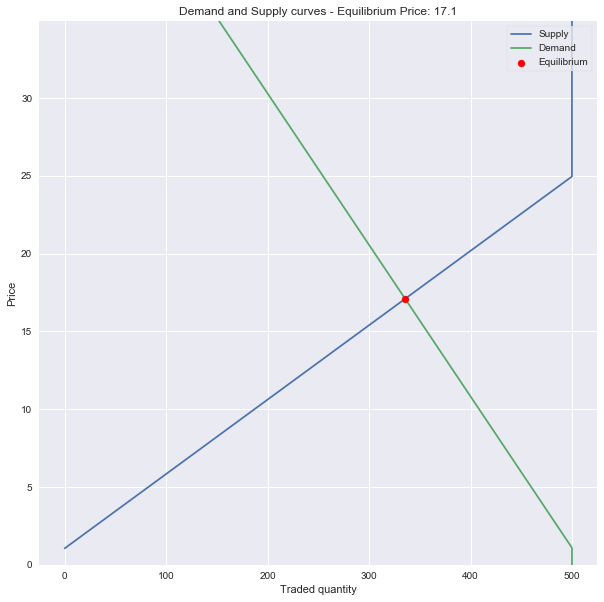

In [560]:
a.supply_demand()

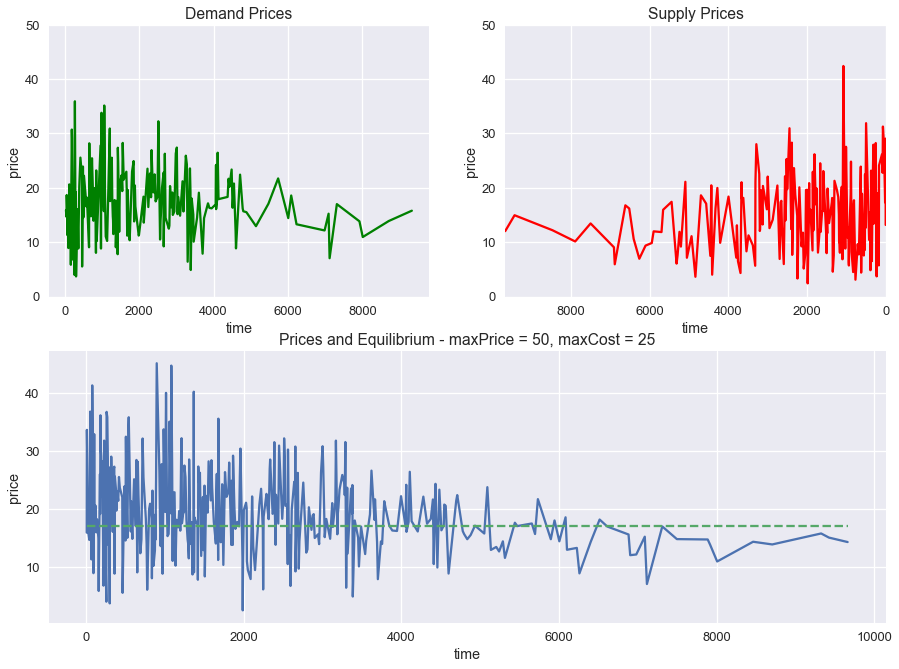

In [561]:
a.price_plots()

### Aggregated effect

In [562]:
from collections import defaultdict
def aggregate_plot_baseline(maxP, maxC, iters, ticks = 8000):
    d = defaultdict()
    for i in range(ticks):
        d[i] = [0, 0]

    for i in range(iters):
        a = ZeroIntelligence(maxP, maxC, time = ticks)
        a.run()
        for index in range(len(a.sale_times)):
            d[a.sale_times[index]][0] += a.prices[index]
            d[a.sale_times[index]][1] += 1




    l = []
    for i in range(ticks):
        if d[i] != [0, 0]:
            l.append(d[i][0]/d[i][1])
        else:
            try:
                l.append(l[i-1])
            except:
                l.append(0)

    fig, ax = plt.subplots(figsize = (16, 5))
    ax.plot(range(ticks), l)
    ax.plot(range(ticks), [a.cross[1] for i in range(ticks)], "--", label = "Optimal")
    ax.legend()
    ax.set_title(f"Average transaction prices computed over {iters} iterations - maxPrice = {maxP}, maxCost = {maxC} ")
    ax.set_xlabel("time")
    ax.set_ylabel("price");

### maxPrice < maxCost

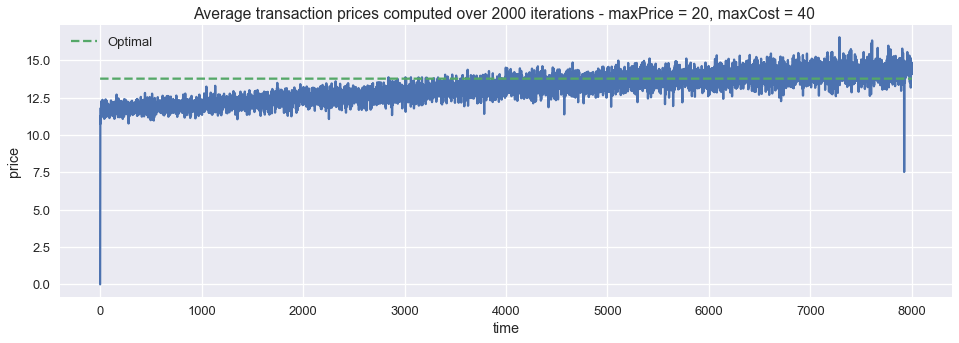

In [563]:
aggregate_plot_baseline(maxP = 20, maxC = 40, iters = 2000)

### maxPrice > maxCost

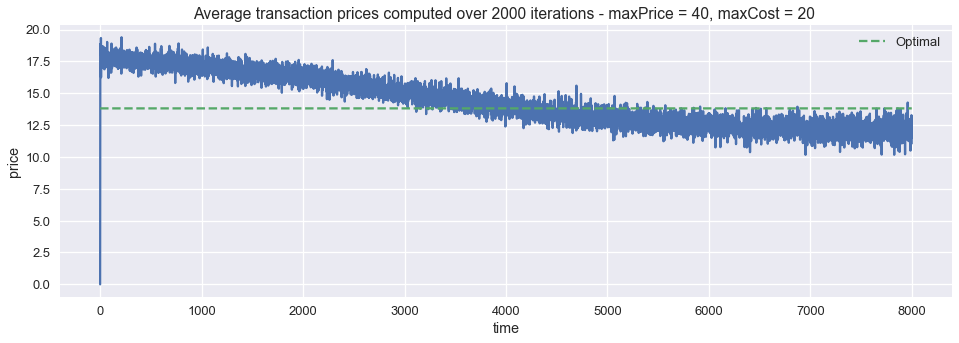

In [564]:
aggregate_plot_baseline(maxP = 40, maxC = 20, iters = 2000)

## Flat Supply curve

In [565]:
class ZeroIntelligence():
    def __init__(self, maxPrice, maxCost, n_buyers = 500, n_sellers = 500, time = 8000, Pmin = 1):
        self.maxPrice = maxPrice
        self.maxCost = maxCost
        self.n_buyers = n_buyers
        self.n_sellers = n_sellers
        self.time = time
        
        #supply and demand are used to plot the D and S curves
        self.supply = []
        self.demand = []
        
        self.buyers = []
        for b in range(self.n_buyers):
            value = np.random.uniform(Pmin, self.maxPrice)
            self.buyers.append({"id": b, "value": value})
            self.demand.append(value)
        
        self.sellers = []
        for s in range(self.n_sellers):
            cost = self.maxCost
            self.sellers.append({"id": s, "cost": cost})
            self.supply.append(cost)
        
        self.prices = []
        self.sale_times = []
        
        self.demand_prices = []
        self.demand_times = []
        self.supply_prices = []
        self.supply_times = []
        
        
        # Compute the equilibrium price
        
        #line 1
        A = [0, min(self.supply)]
        B = [self.n_sellers, max(self.supply)]
        #line 2
        C = [0, max(self.demand)]
        D = [self.n_buyers, min(self.demand)]


        def line_intersection(line1, line2):
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div == 0:
                raise Exception('lines do not intersect')

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            return x, y

        self.cross = line_intersection((A, B), (C, D))
    
    
    def run(self):
        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice} #Initialize the order book
        
        for iteration in range(self.time):
            
            buyer_or_seller = np.random.random()
            if len(self.buyers) == 0 or len(self.sellers) == 0: #If no trades can be done
                continue
            
            elif buyer_or_seller < 0.5: #then we extract a buyer
                agent = random.sample(self.buyers, 1)[0]
                offer = np.random.uniform(0, agent["value"])
                # Set the new best ask if the offer from the seller is the best one so far.
                if offer > book["HighestOffer"]:
                    best_buyer = agent
                    book["HighestOffer"] = offer
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["LowestAsk"])
                        self.sale_times.append(iteration)
                        
                        self.demand_prices.append(book["LowestAsk"])
                        self.demand_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
                        
            elif buyer_or_seller >= 0.5: #then we extract a seller
                agent = random.sample(self.sellers, 1)[0]
                # Contrary to a buyer, a seller will not sell if his cost is greater than maxPrice
                if agent["cost"] > self.maxPrice:
                    continue
                else:
                    ask = np.random.uniform(agent["cost"], self.maxPrice)
                # Set the new best ask if the offer from the seller is the best one so far.
                if ask < book["LowestAsk"]:
                    best_seller = agent
                    book["LowestAsk"] = ask
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["HighestOffer"])
                        self.sale_times.append(iteration)
                        
                        self.supply_prices.append(book["LowestAsk"])
                        self.supply_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
    
    
    def supply_demand(self):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_title(f"Demand and Supply curves - Equilibrium Price: {round(self.cross[1], 2)}")

        ax.set_xlim(left = 0, auto = True)
        ax.set_ylim([0, max(self.supply) * 1.4])
        
        ax.set_ylabel("Price")
        ax.set_xlabel("Traded quantity")
        
        ax.plot((0, self.n_sellers, self.n_sellers), (min(self.supply), max(self.supply), max(self.supply) ** max(self.supply)), label = "Supply", zorder = 1)
        ax.plot((0, self.n_buyers, self.n_buyers), (max(self.demand), min(self.demand), 0), label = "Demand", zorder = 2)
        ax.scatter(self.cross[0], self.cross[1], zorder = 3, c = "r", label = "Equilibrium")
        
        ax.legend(frameon = True, fancybox = True);
        
    
    def price_plots(self):
        sns.set()
        sns.set_context("talk")

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize = (15, 11))

        ax0 = plt.subplot(gs[0, 0])
        ax0.plot(self.demand_times, self.demand_prices, "g")
        ax0.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax0.set_title("Demand Prices")
        ax0.set_xlabel("time")
        ax0.set_ylabel("price")
        
        ax1 = plt.subplot(gs[0, 1])
        ax1.plot(self.supply_times, self.supply_prices, "r")
        ax1.set_xlim(max(self.supply_times), min(self.supply_times))
        ax1.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax1.set_title("Supply Prices")
        ax1.set_xlabel("time")
        ax1.set_ylabel("price")


        ax2 = plt.subplot(gs[1, :])
        ax2.plot(self.sale_times, self.prices)
        ax2.plot(self.sale_times, [self.cross[1] for i in range(len(self.sale_times))], "--")
        ax2.set_title(f"Prices and Equilibrium - maxPrice = {self.maxPrice}, maxCost = {self.maxCost}")
        ax2.set_xlabel("time")
        ax2.set_ylabel("price");

In [566]:
a = ZeroIntelligence(50, 25)
a.run()

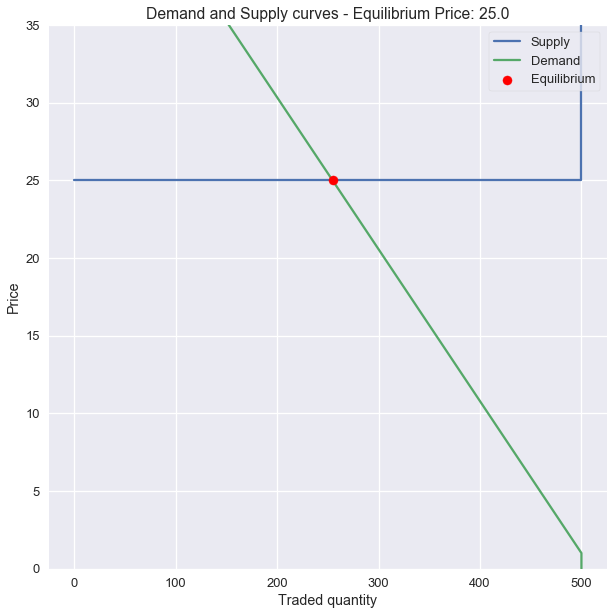

In [567]:
a.supply_demand()

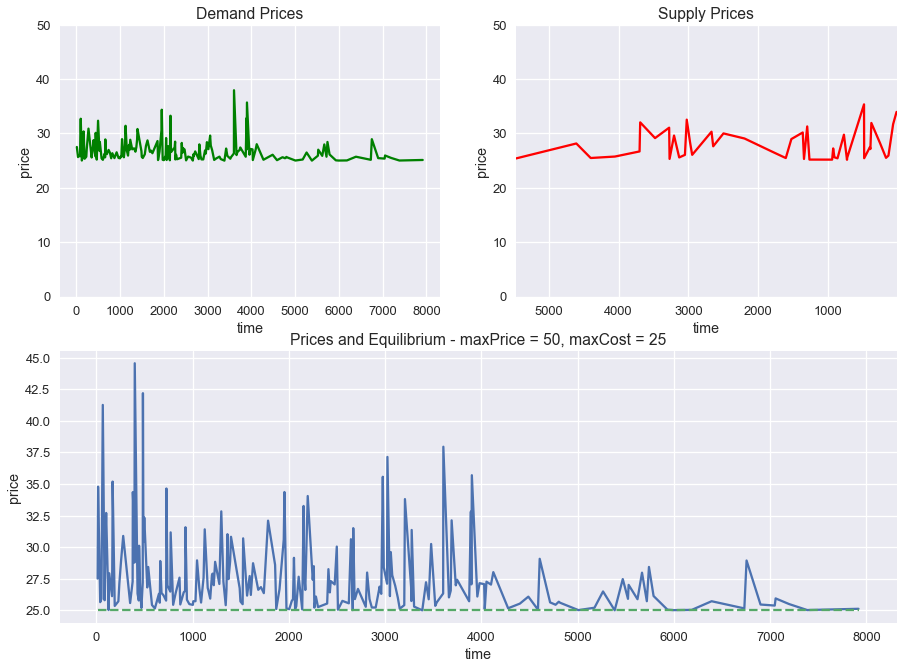

In [568]:
a.price_plots()

### Aggregated Effect

In [569]:
from collections import defaultdict
def aggregate_plot_flatsupply(maxP, maxC, iters, ticks = 8000):
    expected = []

    d = defaultdict()
    for i in range(ticks):
        d[i] = [0, 0]

    for i in range(iters):
        a = ZeroIntelligence(maxP, maxC, time = ticks)
        a.run()
        for index in range(len(a.sale_times)):
            d[a.sale_times[index]][0] += a.prices[index]
            d[a.sale_times[index]][1] += 1
            expected.append(a.cross[1] + (max(a.demand) - a.cross[1]) / 3)




    l = []
    for i in range(ticks):
        if d[i] != [0, 0]:
            l.append(d[i][0]/d[i][1])
        else:
            try:
                l.append(l[i-1])
            except:
                l.append(0)

    fig, ax = plt.subplots(figsize = (16, 5))
    ax.plot(range(ticks), l)
    exm = np.mean(expected)
    ax.plot(range(ticks), [exm for i in range(ticks)], "--", label = "Cliff et al.")
    ax.plot(range(ticks), [a.cross[1] for i in range(ticks)], "--", label = "Optimal")
    ax.legend()
    ax.set_title(f"Average transaction prices computed over {iters} iterations - maxPrice = {maxP}, maxCost = {maxC} ")
    ax.set_xlabel("time")
    ax.set_ylabel("price");

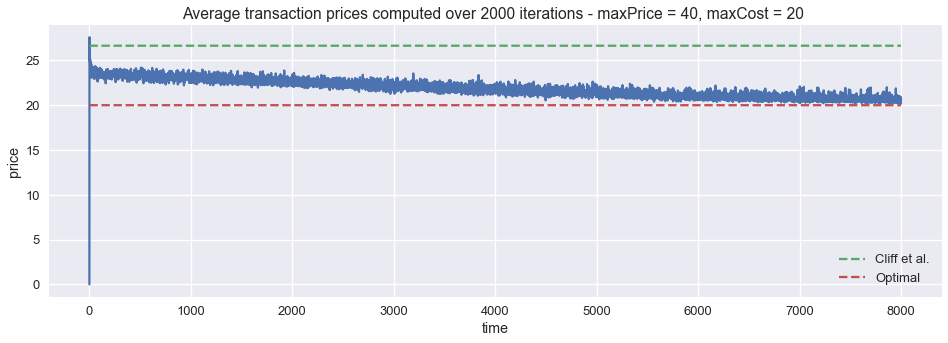

In [570]:
aggregate_plot_flatsupply(maxP = 40, maxC = 20, iters = 2000)

## Flat Demand curve

In [571]:
class ZeroIntelligence():
    def __init__(self, maxPrice, maxCost, n_buyers = 500, n_sellers = 500, time = 8000, Pmin = 1):
        self.maxPrice = maxPrice
        self.maxCost = maxCost
        self.n_buyers = n_buyers
        self.n_sellers = n_sellers
        self.time = time
        
        #supply and demand are used to plot the D and S curves
        self.supply = []
        self.demand = []
        
        self.buyers = []
        for b in range(self.n_buyers):
            value = self.maxPrice
            self.buyers.append({"id": b, "value": value})
            self.demand.append(value)
        
        self.sellers = []
        for s in range(self.n_sellers):
            cost = np.random.uniform(Pmin, self.maxCost)
            self.sellers.append({"id": s, "cost": cost})
            self.supply.append(cost)
        
        self.prices = []
        self.sale_times = []
        
        self.demand_prices = []
        self.demand_times = []
        self.supply_prices = []
        self.supply_times = []
        
        
        # Compute the equilibrium price
        
        #line 1
        A = [0, min(self.supply)]
        B = [self.n_sellers, max(self.supply)]
        #line 2
        C = [0, max(self.demand)]
        D = [self.n_buyers, min(self.demand)]


        def line_intersection(line1, line2):
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div == 0:
                raise Exception('lines do not intersect')

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            return x, y

        self.cross = line_intersection((A, B), (C, D))
    
    
    def run(self):
        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice} #Initialize the order book
        
        for iteration in range(self.time):
            
            buyer_or_seller = np.random.random()
            if len(self.buyers) == 0 or len(self.sellers) == 0: #If no trades can be done
                continue
            
            elif buyer_or_seller < 0.5: #then we extract a buyer
                agent = random.sample(self.buyers, 1)[0]
                offer = np.random.uniform(0, agent["value"])
                # Set the new best ask if the offer from the seller is the best one so far.
                if offer > book["HighestOffer"]:
                    best_buyer = agent
                    book["HighestOffer"] = offer
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["LowestAsk"])
                        self.sale_times.append(iteration)
                        
                        self.demand_prices.append(book["LowestAsk"])
                        self.demand_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
                        
            elif buyer_or_seller >= 0.5: #then we extract a seller
                agent = random.sample(self.sellers, 1)[0]
                # Contrary to a buyer, a seller will not sell if his cost is greater than maxPrice
                if agent["cost"] > self.maxPrice:
                    continue
                else:
                    ask = np.random.uniform(agent["cost"], self.maxPrice)
                # Set the new best ask if the offer from the seller is the best one so far.
                if ask < book["LowestAsk"]:
                    best_seller = agent
                    book["LowestAsk"] = ask
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["HighestOffer"])
                        self.sale_times.append(iteration)
                        
                        self.supply_prices.append(book["LowestAsk"])
                        self.supply_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
    
    
    def supply_demand(self):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_title(f"Demand and Supply curves - Equilibrium Price: {round(self.cross[1], 2)}")

        ax.set_xlim(left = 0, auto = True)
        ax.set_ylim([0, max(self.supply) * 1.4])
        
        ax.set_ylabel("Price")
        ax.set_xlabel("Traded quantity")
        
        ax.plot((0, self.n_sellers, self.n_sellers), (min(self.supply), max(self.supply), max(self.supply) ** max(self.supply)), label = "Supply", zorder = 1)
        ax.plot((0, self.n_buyers, self.n_buyers), (max(self.demand), min(self.demand), 0), label = "Demand", zorder = 2)
        ax.scatter(self.cross[0], self.cross[1], zorder = 3, c = "r", label = "Equilibrium")
        
        ax.legend(frameon = True, fancybox = True);
        
    
    def price_plots(self):
        sns.set()
        sns.set_context("talk")

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize = (15, 11))

        ax0 = plt.subplot(gs[0, 0])
        ax0.plot(self.demand_times, self.demand_prices, "g")
        ax0.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax0.set_title("Demand Prices")
        ax0.set_xlabel("time")
        ax0.set_ylabel("price")
    
        ax1 = plt.subplot(gs[0, 1])
        ax1.plot(self.supply_times, self.supply_prices, "r")
        ax1.set_xlim(max(self.supply_times), min(self.supply_times))
        ax1.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax1.set_title("Supply Prices")
        ax1.set_xlabel("time")
        ax1.set_ylabel("price")

        ax2 = plt.subplot(gs[1, :])
        ax2.plot(self.sale_times, self.prices)
        ax2.plot(self.sale_times, [self.cross[1] for i in range(len(self.sale_times))], "--")
        ax2.set_title(f"Prices and Equilibrium - maxPrice = {self.maxPrice}, maxCost = {self.maxCost}")
        ax2.set_xlabel("time")
        ax2.set_ylabel("price");

In [572]:
a = ZeroIntelligence(20, 25, time = 20000)
a.run()

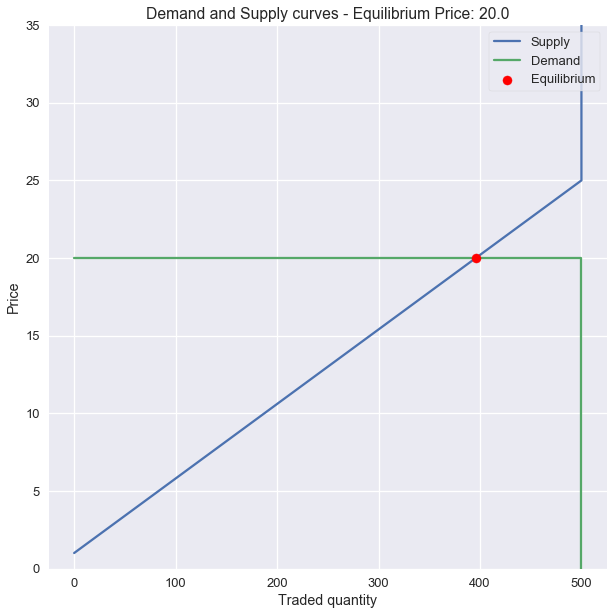

In [573]:
a.supply_demand()

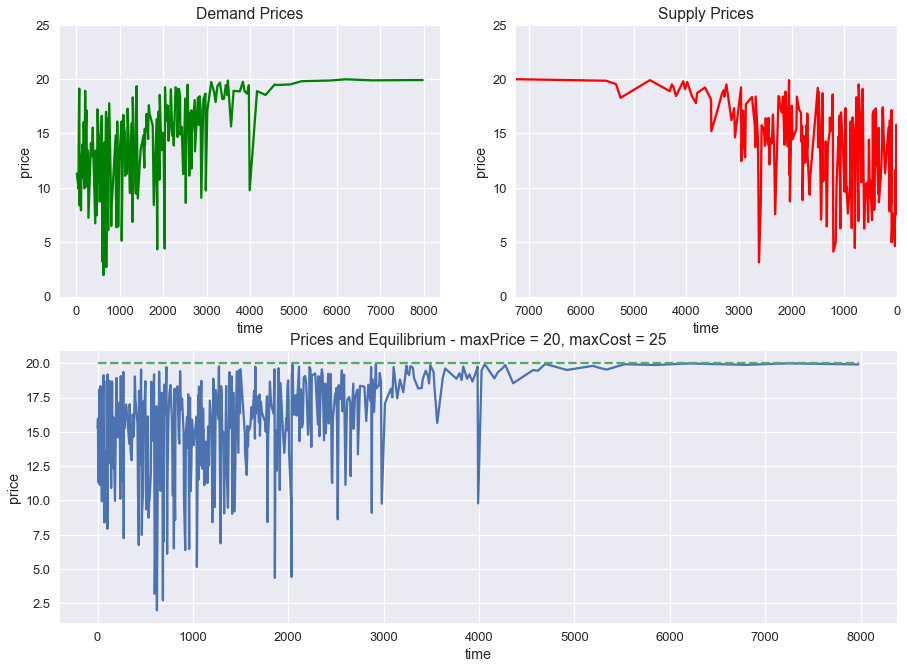

In [574]:
a.price_plots()

## Flat Demand and Supply with excess Supply

In [575]:
class ZeroIntelligence():
    def __init__(self, maxPrice, maxCost, n_buyers = 500, n_sellers = 500, time = 8000, Pmin = 1):
        self.maxPrice = maxPrice
        self.maxCost = maxCost
        self.n_buyers = n_buyers
        self.n_sellers = n_sellers
        self.time = time
        
        #supply and demand are used to plot the D and S curves
        self.supply = []
        self.demand = []
        
        self.buyers = []
        for b in range(self.n_buyers):
            value = self.maxPrice
            self.buyers.append({"id": b, "value": value})
            self.demand.append(value)
        
        self.sellers = []
        for s in range(self.n_sellers):
            cost = self.maxCost
            self.sellers.append({"id": s, "cost": cost})
            self.supply.append(cost)
        
        self.prices = []
        self.sale_times = []
        
        self.demand_prices = []
        self.demand_times = []
        self.supply_prices = []
        self.supply_times = []
    
    
    def run(self):
        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice} #Initialize the order book
        
        for iteration in range(self.time):
            
            buyer_or_seller = np.random.random()
            if len(self.buyers) == 0 or len(self.sellers) == 0: #If no trades can be done
                continue
            
            elif buyer_or_seller < 0.5: #then we extract a buyer
                agent = random.sample(self.buyers, 1)[0]
                offer = np.random.uniform(0, agent["value"])
                # Set the new best ask if the offer from the seller is the best one so far.
                if offer > book["HighestOffer"]:
                    best_buyer = agent
                    book["HighestOffer"] = offer
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["LowestAsk"])
                        self.sale_times.append(iteration)
                        
                        self.demand_prices.append(book["LowestAsk"])
                        self.demand_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
                        
            elif buyer_or_seller >= 0.5: #then we extract a seller
                agent = random.sample(self.sellers, 1)[0]
                # Contrary to a buyer, a seller will not sell if his cost is greater than maxPrice
                if agent["cost"] > self.maxPrice:
                    continue
                else:
                    ask = np.random.uniform(agent["cost"], self.maxPrice)
                # Set the new best ask if the offer from the seller is the best one so far.
                if ask < book["LowestAsk"]:
                    best_seller = agent
                    book["LowestAsk"] = ask
                    # Then, if the LowestAsk is less than the HighestOffer, do the trade.
                    if book["LowestAsk"] < book["HighestOffer"]:
                        self.prices.append(book["HighestOffer"])
                        self.sale_times.append(iteration)
                        
                        self.supply_prices.append(book["LowestAsk"])
                        self.supply_times.append(iteration)
                        
                        self.sellers.remove(best_seller)
                        self.buyers.remove(best_buyer)
                        book = {"HighestOffer": -1, "LowestAsk": self.maxCost + self.maxPrice}
    
    
    def supply_demand(self):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_title(f"Demand and Supply curves")

        ax.set_xlim(left = 0, auto = True)
        ax.set_ylim([0, max(self.supply) * 1.4])
        
        ax.set_ylabel("Price")
        ax.set_xlabel("Traded quantity")
        
        ax.plot((0, self.n_sellers, self.n_sellers), (min(self.supply), max(self.supply), max(self.supply) ** max(self.supply)), label = "Supply", zorder = 1)
        ax.plot((0, self.n_buyers, self.n_buyers), (max(self.demand), min(self.demand), 0), label = "Demand", zorder = 2)
        
        ax.legend(frameon = True, fancybox = True);
        
    
    def price_plots(self):
        sns.set()
        sns.set_context("talk")

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize = (15, 11))

        ax0 = plt.subplot(gs[0, 0])
        ax0.plot(self.demand_times, self.demand_prices, "g")
        ax0.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax0.set_title("Demand Prices")
        ax0.set_xlabel("time")
        ax0.set_ylabel("price")
        
        ax1 = plt.subplot(gs[0, 1])
        ax1.plot(self.supply_times, self.supply_prices, "r")
        ax1.set_xlim(max(self.supply_times), min(self.supply_times))
        ax1.set_ylim(0, max([self.maxCost, self.maxPrice]))
        ax1.set_title("Supply Prices")
        ax1.set_xlabel("time")
        ax1.set_ylabel("price")


        ax2 = plt.subplot(gs[1, :])
        ax2.plot(self.sale_times, self.prices)
        ax2.set_title(f"Prices and Equilibrium - maxPrice = {self.maxPrice}, maxCost = {self.maxCost}")
        ax2.set_xlabel("time")
        ax2.set_ylabel("price");

In [576]:
a = ZeroIntelligence(30, 25, n_buyers = 300, time = 8000)
a.run()

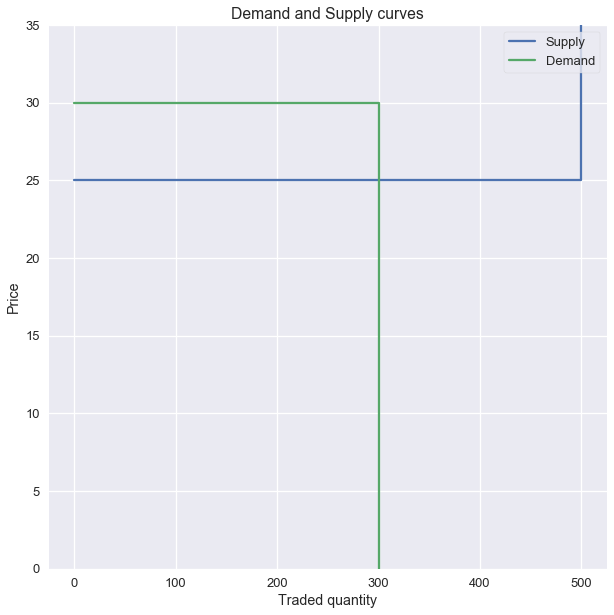

In [577]:
a.supply_demand()

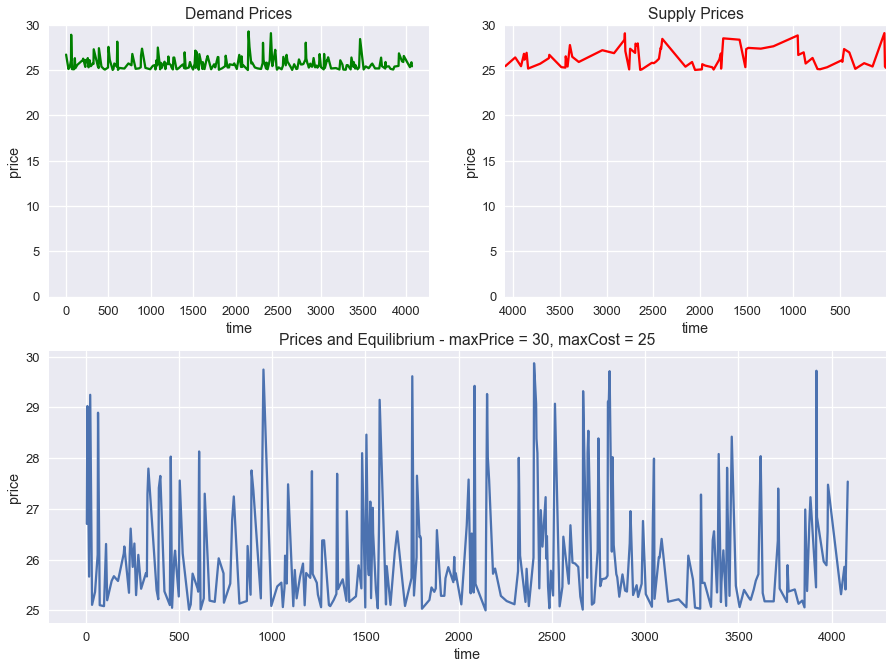

In [578]:
a.price_plots()

### Aggregated Effect

In [579]:
from collections import defaultdict
def aggregate_plot_flatsupplydemand(maxP, maxC, iters, nbuyers = 300, nsellers = 500, ticks = 8000):
    expected = []

    d = defaultdict()
    for i in range(ticks):
        d[i] = [0, 0]

    for i in range(iters):
        a = ZeroIntelligence(maxPrice = maxP, maxCost = maxC, n_buyers = nbuyers, n_sellers = nsellers, time = ticks)
        a.run()
        for index in range(len(a.sale_times)):
            d[a.sale_times[index]][0] += a.prices[index]
            d[a.sale_times[index]][1] += 1
            expected.append(0.5 * (25 + min(a.demand)))




    l = []
    for i in range(ticks):
        if d[i] != [0, 0]:
            l.append(d[i][0]/d[i][1])
        else:
            try:
                l.append(l[i-1])
            except:
                l.append(0)

    fig, ax = plt.subplots(figsize = (16, 5))
    ax.plot(range(ticks), l)
    exm = np.mean(expected)
    ax.plot(range(ticks), [exm for i in range(ticks)], "--", label = "Cliff et al.")
    ax.plot(range(ticks), [maxC for i in range(ticks)], "--", label = "Optimal")
    ax.legend()
    ax.set_title(f"Average transaction prices computed over {iters} iterations - maxPrice = {maxP}, maxCost = {maxC} ")
    ax.set_xlabel("time")
    ax.set_ylabel("price");

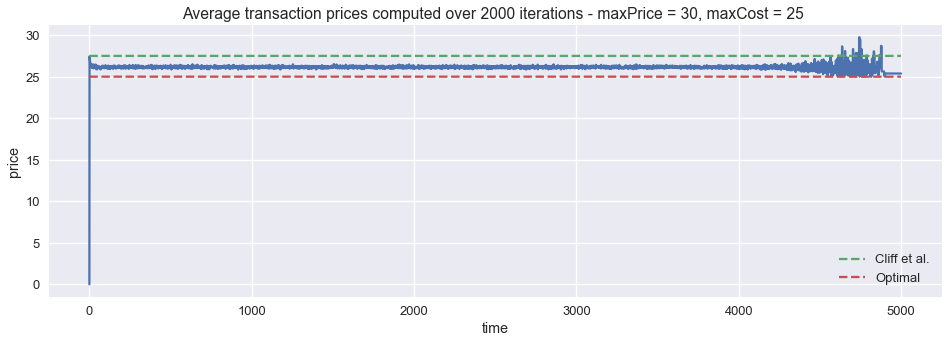

In [580]:
aggregate_plot_flatsupplydemand(maxP = 30, maxC = 25, iters = 2000, nbuyers = 300, ticks = 5000)